In [601]:
import numpy.linalg
from PIL import Image
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Taking in the Image

(224, 224)


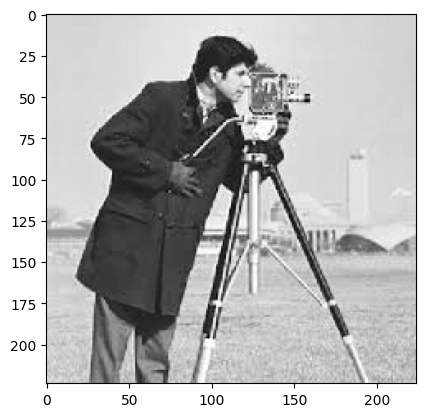

In [602]:
image_path = "images.jpg"
image = Image.open(image_path).convert('L')
image = np.array(image)
# show the image
plt.imshow(image,cmap='gray')
print(image.shape)

In [603]:
image

array([[214, 214, 214, ..., 212, 212, 212],
       [214, 214, 214, ..., 212, 212, 212],
       [214, 214, 214, ..., 212, 212, 212],
       ...,
       [226, 222, 211, ..., 167, 182, 178],
       [202, 219, 223, ..., 182, 194, 193],
       [209, 212, 216, ..., 197, 200, 222]], dtype=uint8)

# Compress Image



    # Standardize Image Data


In [604]:
# Centering the data
mean = np.mean(image,axis=0)
mean = mean[None,:]
mean.shape

(1, 224)

In [605]:
image.shape

(224, 224)

In [606]:
image = image - mean
image.shape

(224, 224)

In [607]:
image[0]

array([  3.24553571,   3.48214286,   3.84375   ,   3.26339286,
         3.52232143,   4.64285714,   5.03571429,   5.33928571,
         3.78571429,   3.55803571,   3.72321429,   3.5625    ,
         3.88392857,   3.29017857,   2.70089286,   1.96875   ,
         0.59375   ,   0.38392857,   1.80357143,   6.00892857,
         8.90625   ,  12.28125   ,  15.55357143,  17.08928571,
        19.29910714,  19.49553571,  22.44196429,  35.86160714,
        49.98214286,  62.83928571,  69.36607143,  70.52232143,
        76.12946429,  77.91517857,  79.62946429,  83.50892857,
        84.42857143,  85.53125   ,  89.29017857,  93.94196429,
       103.45982143, 103.31696429, 101.77232143, 104.0625    ,
       104.96875   , 104.27232143, 104.86160714, 105.17857143,
       102.63392857, 100.42857143, 100.66071429, 100.52678571,
        98.11607143, 102.39732143, 121.39732143, 118.76785714,
       120.55357143, 119.83928571, 122.60267857, 122.68303571,
       124.54017857, 125.45089286, 125.43303571, 125.48

    # Calculate Covariance Matrix


In [608]:
C = np.cov(image)
C.shape

(224, 224)


    # Calculate Eigen Values & Vectors


In [609]:
eigen_values, eigen_vectors = np.linalg.eig(C)
eigen_values.shape , eigen_vectors.shape


((224,), (224, 224))

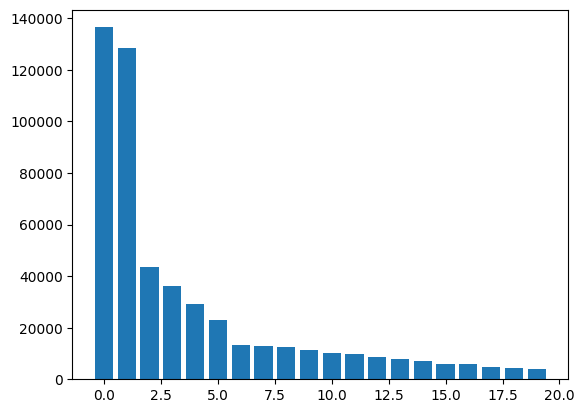

In [610]:
# plotting the first k eigen values as bar graph

test = eigen_values[0:20]

plt.bar(range(len(test)),test)
plt.show()



    # Pick Principals to cover P% of the information already existing


In [611]:
p = 0.9
explained_variance = eigen_values / np.sum(eigen_values)
cumulative_vairance = np.cumsum(explained_variance)
k = np.argmax(cumulative_vairance >= p) + 1 # Picking top k principal components that cover p percentage of the data
k

22


    # Calculate Feature Matrix
    


In [612]:
feature_matrix = eigen_vectors[:, np.argsort(eigen_values)[::-1][:k]]
feature_matrix.shape

(224, 22)

    # Calculate Compressed Image
    


In [613]:
class CompressedImage:
        def __init__(self, compressed_data, feature_matrix_transpose, mean):
            self.compressed_data = compressed_data
            self.feature_matrix_transpose = feature_matrix_transpose
            self.mean = mean

In [614]:
feature_matrix.shape , image.shape

((224, 22), (224, 224))

In [615]:
compressed_image = CompressedImage(compressed_data=feature_matrix.T @ image, feature_matrix_transpose=feature_matrix.T, mean=mean)


In [616]:
compressed_image.compressed_data.shape

(22, 224)

(224, 22)


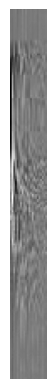

In [617]:
t = compressed_image.compressed_data.T
# show the image
plt.imshow(t,cmap='gray')
plt.axis('off')
print(t.shape)


# Decompress Image
    # Load Image
    # Reverse Compression Equation
    # Get Original Matrix
    # Return Decompresssed Image

In [618]:
decompressed_image = Image.fromarray((compressed_image.compressed_data.T @ compressed_image.feature_matrix_transpose).T + compressed_image.mean)
decompressed_image = decompressed_image.convert('L')

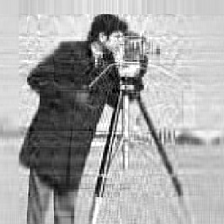

In [619]:
# show the image
decompressed_image

# Putting it All Together

In [636]:
class ImageCompressorPCA:
    def __init__(self, p=1, number_of_components=None):
        self.p = p
        self.number_of_components = number_of_components
        self.mean = None
        self.compressed_data = None
        self.feature_matrix = None
        self.cov = None
        self.eigen_values = None
        self.eigen_vectors = None
    
    def transform(self, data):
        return self.__pca(data)
    
    def inverse_transform(self, data):
        # No need for pinv here since we're using the original feature matrix
        decompressed_data = (data @ self.feature_matrix.T) + self.mean
        # normalize the data 
        decompressed_data = (decompressed_data - np.min(decompressed_data)) / (np.max(decompressed_data) - np.min(decompressed_data))
        return decompressed_data

    def __pca(self, data):
        # Centering the data
        self.mean = np.mean(data, axis=0)
        data = data - self.mean
        
        # Covariance Matrix - corrected to handle the data properly
        self.cov = np.cov(data, rowvar=False)
        
        # Eigenvalues and Eigenvectors
        self.eigen_values, self.eigen_vectors = np.linalg.eigh(self.cov)  # Using eigh for symmetric matrix
        
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigen_values)[::-1]
        self.eigen_values = self.eigen_values[idx]
        self.eigen_vectors = self.eigen_vectors[:, idx]
        
        # Picking P% of information
        explained_variance = self.eigen_values / np.sum(self.eigen_values)
        cumulative_variance = np.cumsum(explained_variance)
        k = np.argmax(cumulative_variance >= self.p) + 1
        
        # Check if no index meets the condition, set k to max possible index
        if k == 1 and cumulative_variance[-1] < self.p:
            k = len(cumulative_variance)
        print(f"Number of components selected: {k}")
        
        # Limit k if number_of_components is specified
        if self.number_of_components is not None:
            k = min(k, self.number_of_components)
        
        # Feature Matrix (using k principal components)
        self.feature_matrix = self.eigen_vectors[:, :k]
        
        # Results
        self.compressed_data = data @ self.feature_matrix
        return self.compressed_data

# Eigen Faces

In [637]:
data=np.load("olivetti_faces.npy")
data.shape

#shuffle the images
np.random.shuffle(data)

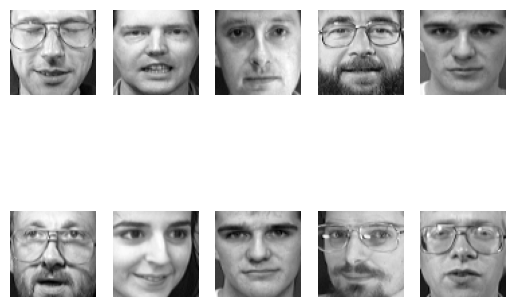

In [638]:
# plotting the first 10 images in a grid

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(data[i],cmap='gray')
    plt.axis('off')

In [639]:
# squeezing the last two dimensions
data = data.reshape(400,-1)
data.shape

(400, 4096)

In [640]:
sample_data = data
sample_data.shape

(400, 4096)

In [641]:
pca = ImageCompressorPCA(p=1)
compressed_images = pca.transform(data)
compressed_images.shape

Number of components selected: 399


(400, 399)

(-0.5, 63.5, 63.5, -0.5)

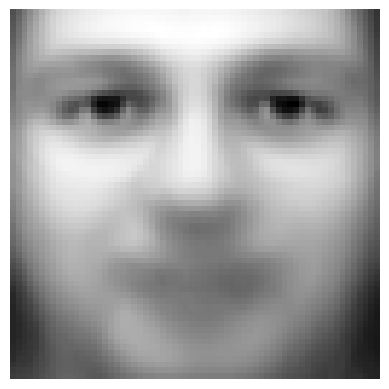

In [642]:
# plotting the mean
plt.imshow(pca.mean.reshape(64,64),cmap='gray')
plt.axis('off')


In [643]:
temp = pca.feature_matrix.T
temp.shape


(399, 4096)

In [644]:
temp[i][0]

0.01962218611752386

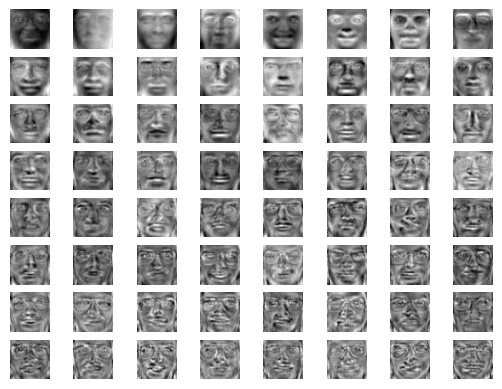

In [645]:
# visualizing the feature matrix
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(temp[i].reshape(64,64),cmap='gray')
    plt.axis('off')

In [646]:
# visualizing the compressed data
original_images = pca.inverse_transform(compressed_images)
original_images.shape

(400, 4096)

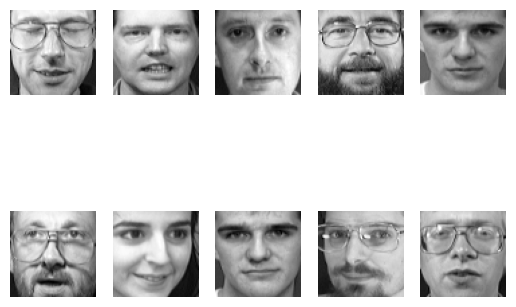

In [647]:
# visualizing the original images
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(original_images[i].reshape(64,64),cmap='gray')
    plt.axis('off')

# Colored Image

(-0.5, 799.5, 799.5, -0.5)

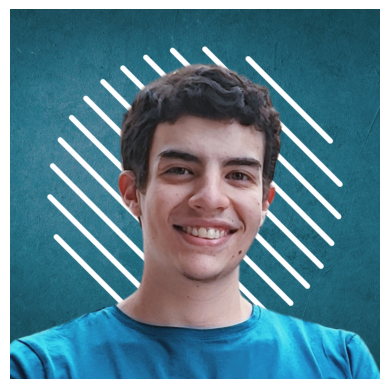

In [649]:
colored_image = Image.open("5.png").convert('RGB')
colored_image = np.array(colored_image)

# show the image
plt.imshow(colored_image)
plt.axis('off')


In [650]:
colored_image.shape


(800, 800, 3)

In [659]:
num = 20
R = ImageCompressorPCA(number_of_components=num)
G = ImageCompressorPCA(number_of_components=num)
B = ImageCompressorPCA(number_of_components=num)

In [660]:
red = R.transform(colored_image[:,:,0])
green = G.transform(colored_image[:,:,1])
blue = B.transform(colored_image[:,:,2])

red.shape , green.shape , blue.shape

Number of components selected: 800
Number of components selected: 800
Number of components selected: 799


((800, 20), (800, 20), (800, 20))

In [661]:
# visualizing the compressed data

compressed_image = np.dstack((red, green, blue))

plt.imshow(compressed_image)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1651.9194825273628..1435.8369787613003].


(-0.5, 19.5, 799.5, -0.5)

In [662]:
# getting the original image
r = R.inverse_transform(red)
g = G.inverse_transform(green)
b = B.inverse_transform(blue)

# og = np.dstack((r, g, b))
# og.shape

(-0.5, 799.5, 799.5, -0.5)

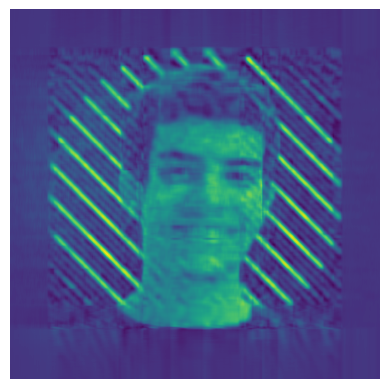

In [663]:
# save the original image
plt.imshow(r)
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

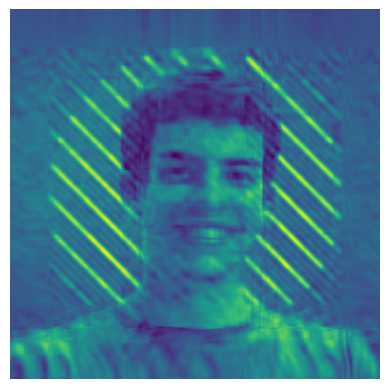

In [664]:
plt.imshow(g)
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

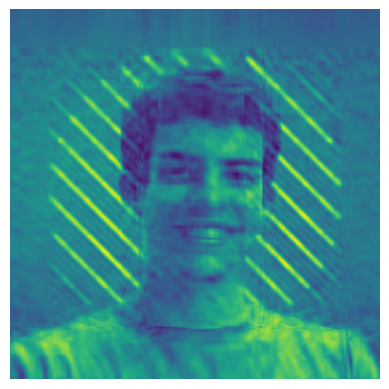

In [665]:
plt.imshow(b)
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

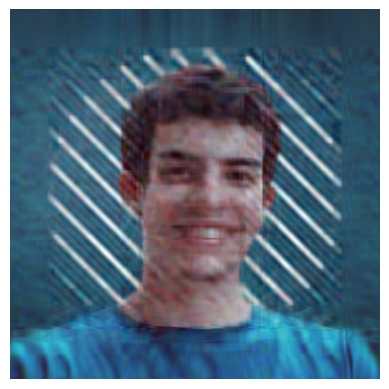

In [666]:
full_image = np.dstack((r, g, b))
plt.imshow(full_image)
plt.axis('off')